<a href="https://colab.research.google.com/github/rafkama/Magang-BVK/blob/main/Forecasting_Data_BVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Forecasting Data***

Forecasting Data menggunakan Metode CNN + LSTM dengan Preprocessing, Visualisasi dilakukan dengan membandingkan Data Test yang tidak menjadi bagian dari Data Train.

Pelatihan (Training) mengambil 80% dari Data Train dan 20% sebagai Data Validation

Dimanfaatkan 2 Data untuk dicoba sebagai *Dummy Data*. Data Pertama adalah data sales dan data kedua adalah data promosi yang keduanya diambil dari Kaggle.
Pembeda kedua data ini adalah jumlah data dimana data pertama berkisar ribuan dan data kedua berkisar 3 juta data.

Perbedaan kedua data ini dilakukan untuk menguji ketangguhan model terhadap jumlah data dan variasi nya.

## **Import**

Import dilakukan untuk memasukkan semua library yang dibutuhkan untuk menjalankan semua program komputasi

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.layers import Conv1D, MaxPooling1D, RepeatVector, TimeDistributed, Flatten
import os

# Ignore warnings
warnings.filterwarnings('ignore')

# Initialize notebook mode for offline Plotly
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Enable inline plotting
%matplotlib inline


## **Import Data**

Menampilkan data sales

In [3]:
#Menampilkan sebagian data
df = pd.read_csv('salesdaily.csv')
df.head(5)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


Menampilkan data promosi

In [2]:
#Menampilkan sebagian data
df = pd.read_csv('trrain.csv')
df.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
# Memeriksa data
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [4]:
df.dtypes

,0
id,int64
date,object
store_nbr,int64
family,object
sales,float64
onpromotion,int64


## **Preprocessing**

Melakukan preprocessing untuk menghilangkan data duplikat dan data yang hilang

In [5]:
df.isnull().sum().sort_values(ascending=False)

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


In [6]:
df.duplicated().any() # use df.drop_duplicates(inplace=True) -> if any duplicates exist in the dataframe

False

In [7]:
# removing missing values
df.dropna(axis=0, inplace=True)

In [8]:
df



,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,2014-01-02,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,2014,1,248,Thursday
1,2014-01-03,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,2014,1,276,Friday
2,2014-01-04,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,2014,1,276,Saturday
3,2014-01-05,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,2014,1,276,Sunday
4,2014-01-06,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,2014,1,276,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2019-10-04,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday
2102,2019-10-05,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday
2103,2019-10-06,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday
2104,2019-10-07,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday


## **Visualisasi Data Train**

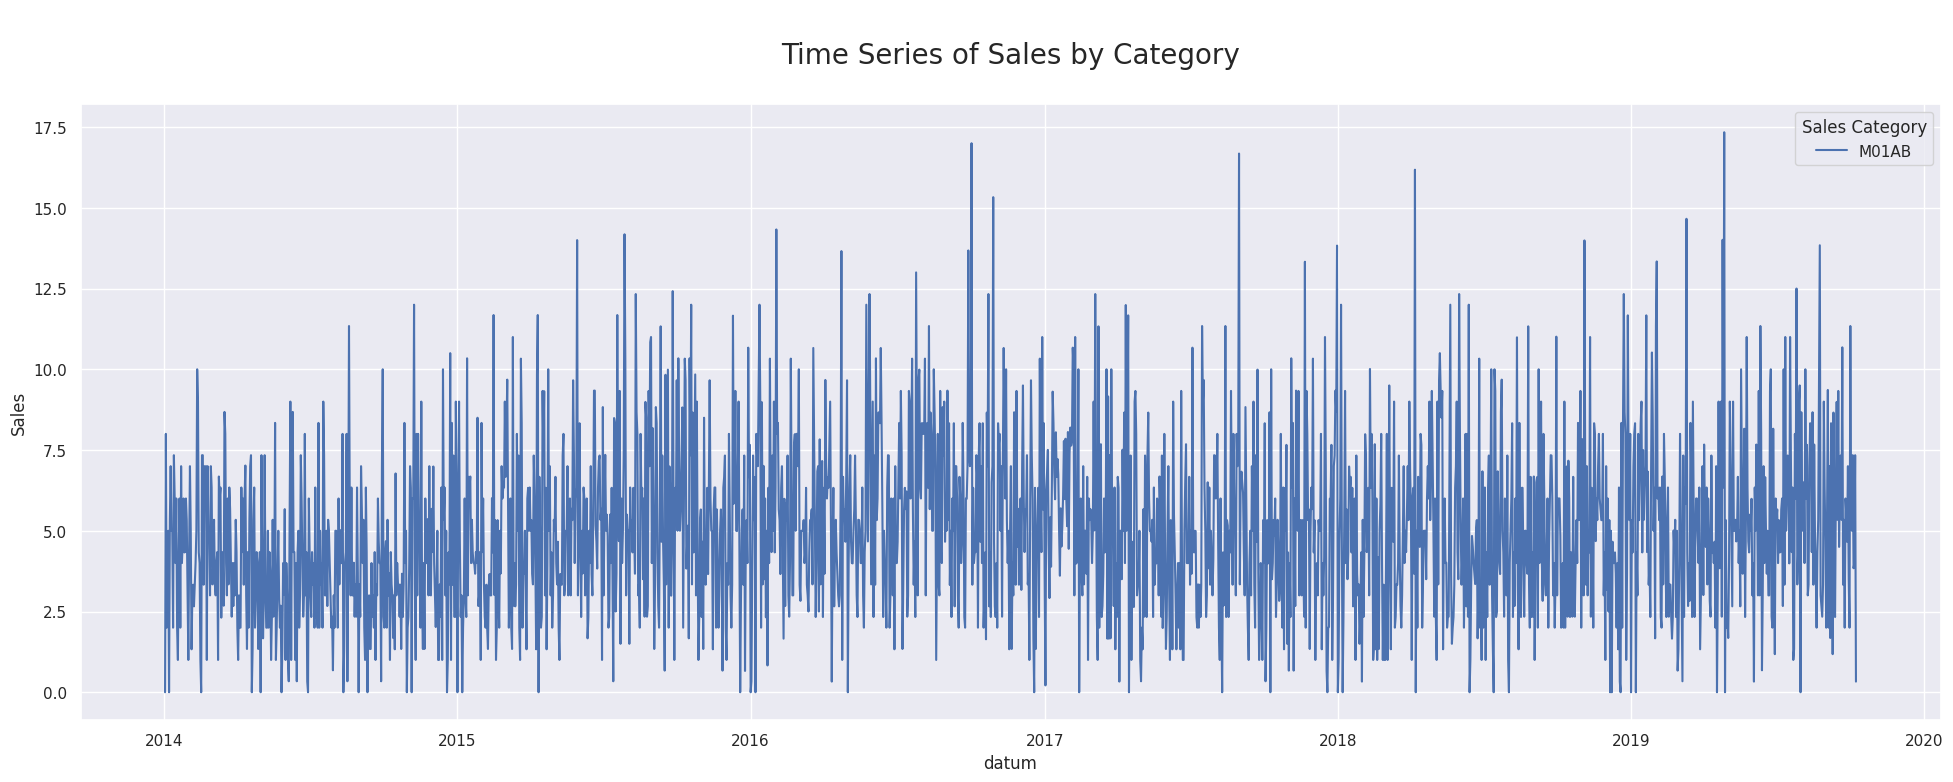

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'datum' is in datetime format
df['datum'] = pd.to_datetime(df['datum'])

# Select the columns for reshaping
columns_to_plot = ['M01AB'] #Pilih data disini

# Melt the DataFrame to long format
df_melted = df.melt(id_vars=['datum'], value_vars=columns_to_plot,
                    var_name='Sales Category', value_name='Sales')

# Set figure size
sns.set(rc={'figure.figsize':(24,8)})

# Create the line plot
ax = sns.lineplot(data=df_melted, x='datum', y='Sales', hue='Sales Category')

# Set the plot title
ax.set_title("\nTime Series of Sales by Category\n", fontsize=20)

# Show the plot
plt.show()

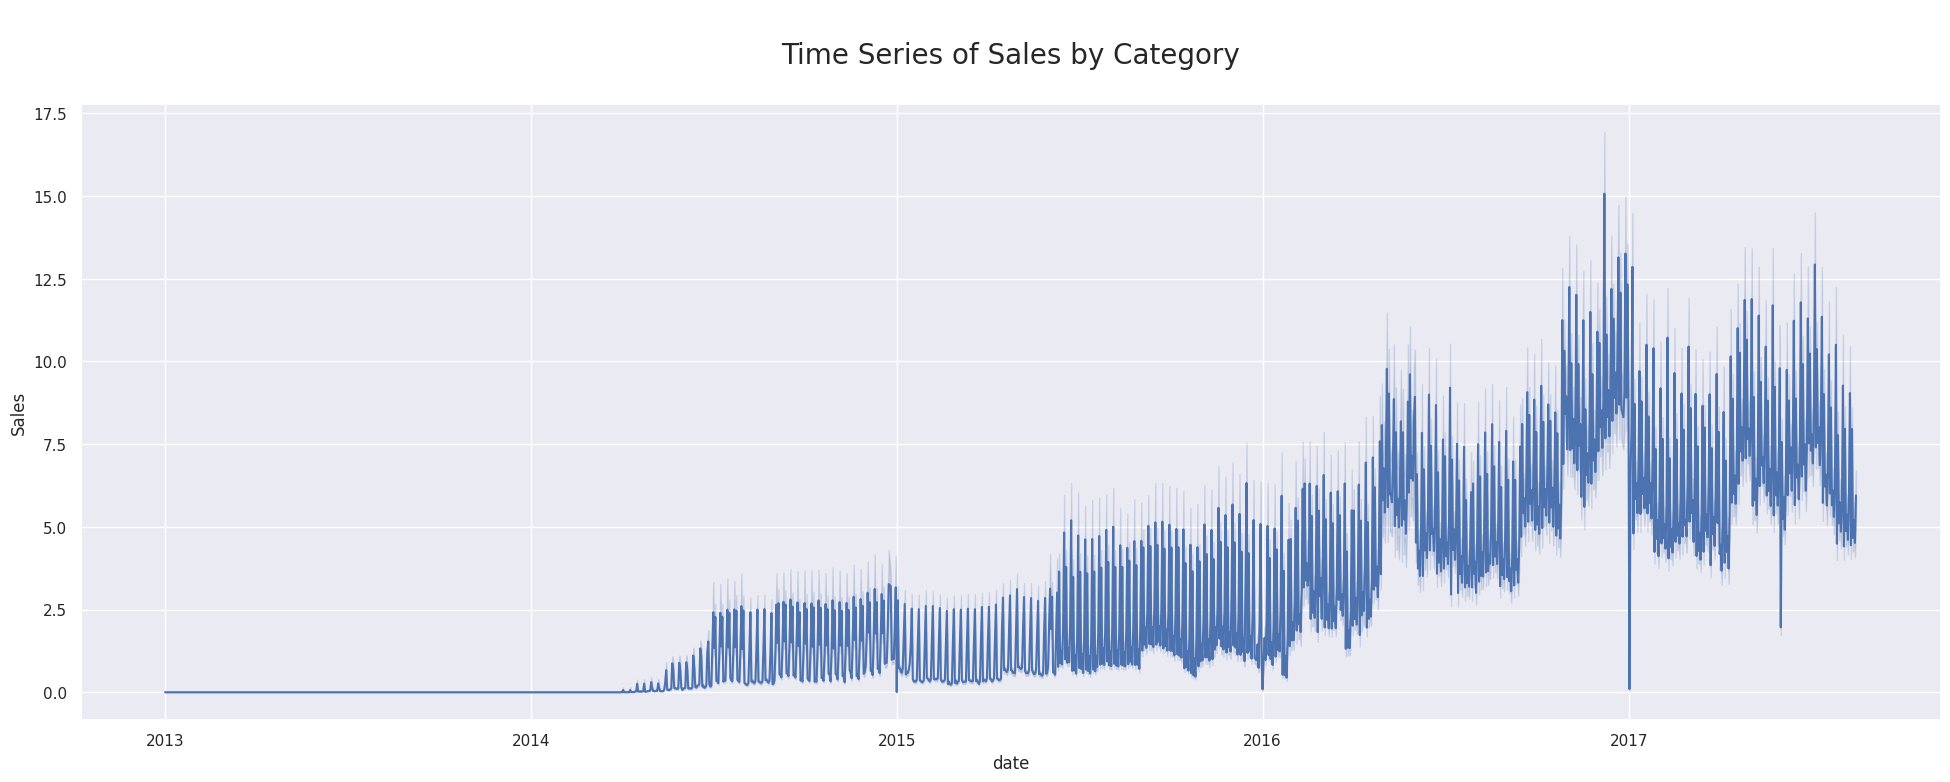

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data creation (for demonstration, you should load your actual data)
# df = pd.read_csv('your_data_file.csv')  # Uncomment this line to load your DataFrame

# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Select the columns for reshaping
columns_to_plot = ['onpromotion']  # Choose your data here

# Check if the specified columns exist in the DataFrame
if 'date' in df.columns and all(col in df.columns for col in columns_to_plot):
    # Melt the DataFrame to long format (optional if only one column)
    df_melted = df.melt(id_vars=['date'], value_vars=columns_to_plot,
                         var_name='Sales Category', value_name='Sales')

    # Set figure size
    sns.set(rc={'figure.figsize': (24, 8)})

    # Create the line plot
    ax = sns.lineplot(data=df_melted, x='date', y='Sales')

    # Set the plot title
    ax.set_title("\nTime Series of Sales by Category\n", fontsize=20)

    # Show the plot
    plt.show()
else:
    print("The specified columns do not exist in the DataFrame.")


## **ADF Test**

Work in Progress

In [10]:
!pip install statsmodels


In [11]:
# from statsmodels.tsa.stattools import adfuller

# # List of columns to test
# columns_to_test = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

# # Loop through each column and perform the ADF test
# for col in columns_to_test:
#     print(f"\nADF Test for {col}:")
#     result = adfuller(df[col].dropna().values, autolag='AIC')  # dropna to avoid issues with NaN
#     print(f'ADF Statistic: {result[0]}')
#     print(f'p-value: {result[1]}')

#     # Print the critical values
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print(f'   {key}: {value}')


In [12]:
# from statsmodels.tsa.stattools import kpss
# result = kpss(df.num_sold.values, regression='c')
# print('\nKPSS Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# for key, value in result[3].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}');

## **Splitting**

Membagi Data

**Data Sales**

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Ensure the 'datum' column is in datetime format
df['datum'] = pd.to_datetime(df['datum'])

# Filter the data for years before 2019 and for the year 2019
df_before_2019 = df[df['Year'] < 2019]
df_2019 = df[df['Year'] == 2019]

# Select the 'M01AB' column for analysis
X = df_before_2019[['M01AB']].values  # Features (before 2019)
Y = df_2019[['M01AB']].values  # Target data for 2019 (test set)

# Split the data into 80% training and 20% validation for data before 2019
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=False)

# Reshape the training and validation data to match the CNN-LSTM input
# Since 'M01AB' is a single column, the timesteps will be 1
timesteps = 1

# Reshape to (samples, timesteps, 1) for training and validation
X_train_series_sub = X_train.reshape((X_train.shape[0], timesteps, 1))
X_val_series_sub = X_val.reshape((X_val.shape[0], timesteps, 1))

# Reshape 2019 data for final testing
X_2019_series_sub = Y.reshape((Y.shape[0], timesteps, 1))

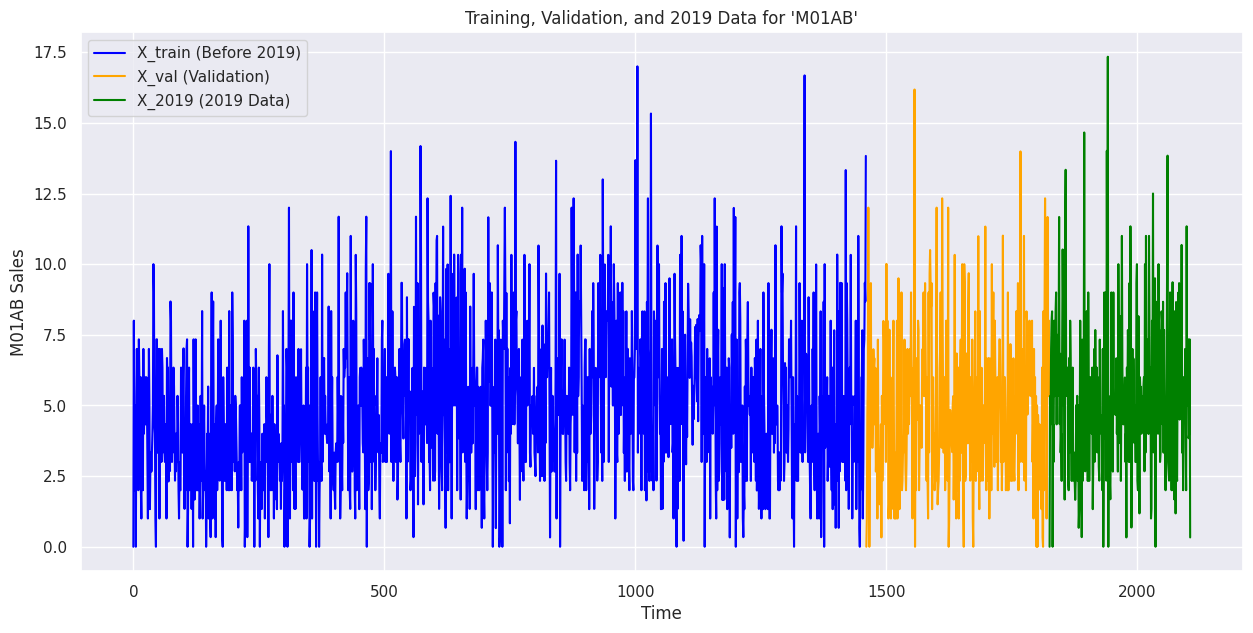

In [14]:
import matplotlib.pyplot as plt

# Reshape Y_train and Y_val to match shapes if needed
X_train_flat = X_train_series_sub.flatten()  # Flattening the data for plotting
X_val_flat = X_val_series_sub.flatten()      # Flattening validation data
X_2019_flat = X_2019_series_sub.flatten()    # Flattening 2019 data

# Prepare the index for plots
index_train = np.arange(0, len(X_train_flat))  # Index for X_train
index_val = np.arange(len(X_train_flat), len(X_train_flat) + len(X_val_flat))  # Index for X_val
index_2019 = np.arange(len(X_train_flat) + len(X_val_flat), len(X_train_flat) + len(X_val_flat) + len(X_2019_flat))  # Index for 2019

# Plot the X_train, X_val, and X_2019 data
plt.figure(figsize=(15, 7))

# Plot X_train
plt.plot(index_train, X_train_flat, label='X_train (Before 2019)', color='blue')

# Plot X_val
plt.plot(index_val, X_val_flat, label='X_val (Validation)', color='orange')

# Plot X_2019
plt.plot(index_2019, X_2019_flat, label='X_2019 (2019 Data)', color='green')

# Add titles and labels
plt.title("Training, Validation, and 2019 Data for 'M01AB'")
plt.xlabel('Time')
plt.ylabel('M01AB Sales')
plt.legend()

# Show the plot
plt.show()



**Data Promosi**

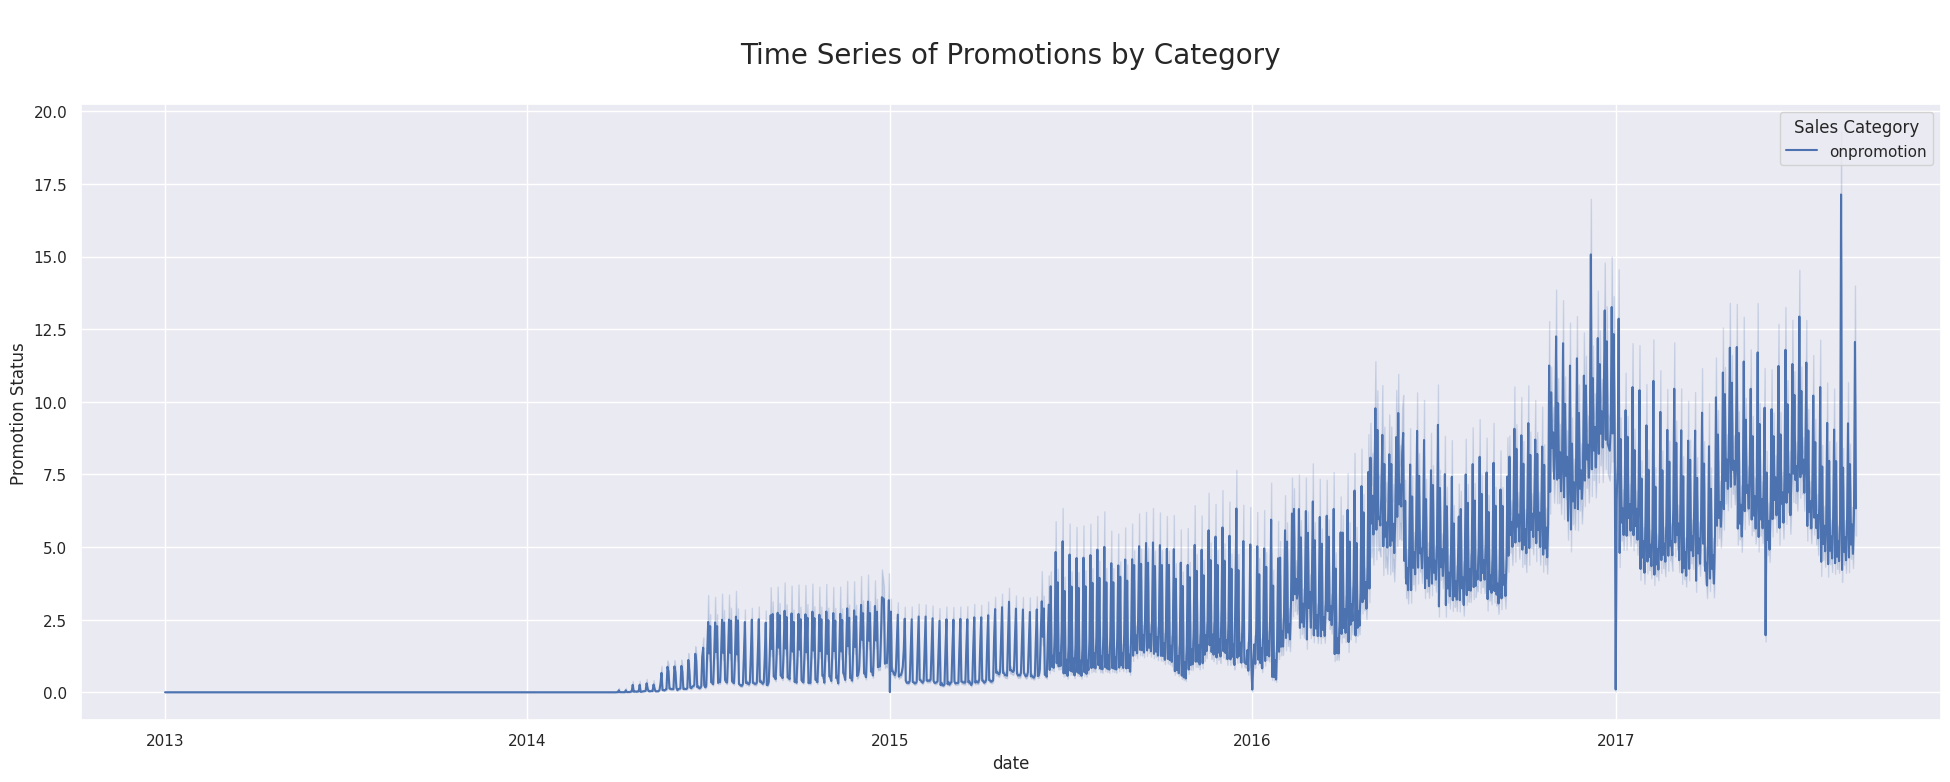

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your train DataFrame
df_train = df.copy()  # Use .copy() to avoid modifying the original DataFrame

# Ensure 'date' is in datetime format for the training dataset
df_train['date'] = pd.to_datetime(df_train['date'])

# Load the test dataset
df_test = pd.read_csv('test.csv')  # Load your test data
df_test['date'] = pd.to_datetime(df_test['date'])

# Select the columns for plotting
columns_to_plot = ['onpromotion']  # Column to plot, adjust as necessary

# Melt the train DataFrame to long format
df_train_melted = df_train.melt(id_vars=['date'], value_vars=columns_to_plot,
                                  var_name='Sales Category', value_name='Promotion Status')

# Melt the test DataFrame to long format
df_test_melted = df_test.melt(id_vars=['date'], value_vars=columns_to_plot,
                                var_name='Sales Category', value_name='Promotion Status')

# Combine train and test data for plotting
df_combined = pd.concat([df_train_melted, df_test_melted], ignore_index=True)

# Set figure size
sns.set(rc={'figure.figsize': (24, 8)})

# Create the line plot
ax = sns.lineplot(data=df_combined, x='date', y='Promotion Status', hue='Sales Category')

# Set the plot title
ax.set_title("\nTime Series of Promotions by Category\n", fontsize=20)

# Show the plot
plt.show()


## Testing

Menguji coba model dengan kedua data

**Data Promosi**

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Ensure 'date' is in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Prepare the data for modeling
# Select 'onpromotion' for training and testing
X_train = df_train[['onpromotion']].values  # Replace 'onpromotion' with your relevant feature
Y_train = df_train[['onpromotion']].values  # Assuming you want to predict 'onpromotion'

X_test = df_test[['onpromotion']].values  # Same column for testing
Y_test = df_test[['onpromotion']].values  # Assuming you also have the target variable in the test set

# Reshape the training and testing data to match the expected input shape of the model
timesteps = 1  # Define your timesteps as needed

X_train_series_sub = X_train.reshape((X_train.shape[0], timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], timesteps, 1))

In [26]:
# Create the CNN-LSTM model
model_cnn_lstm = Sequential()

# Adding layers
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=1, activation='relu',
                           input_shape=(timesteps, 1)))  # L2 regularization could be added here
model_cnn_lstm.add(MaxPooling1D(pool_size=1))

model_cnn_lstm.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model_cnn_lstm.add(Dropout(0.2))  # Dropout layer

model_cnn_lstm.add(Dense(1, kernel_regularizer=l2(0.01)))  # Single output for 'onpromotion'

# Compile the model
adam = Adam()
model_cnn_lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Fit the model on training data
epochs = 5  # Define the number of epochs
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train,
                                       validation_split=0.2,  # Use part of training data for validation
                                       epochs=epochs,
                                       verbose=2)

# Evaluate the model on test data
loss, accuracy = model_cnn_lstm.evaluate(X_test_series_sub, Y_test, verbose=0)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Predict on the test data
predictions = model_cnn_lstm.predict(X_test_series_sub)

# Prepare the predictions for comparison
comparison = pd.DataFrame({
    'Actual': Y_test.flatten(),
    'Predicted': predictions.flatten()
})

print(comparison.head())  # Display the first few predictions for review


Epoch 1/5
75023/75023 - 176s - 2ms/step - accuracy: 0.9041 - loss: 2.1952 - val_accuracy: 0.6443 - val_loss: 0.6369
Epoch 2/5
75023/75023 - 215s - 3ms/step - accuracy: 0.9054 - loss: 1.5893 - val_accuracy: 0.6443 - val_loss: 0.2996
Epoch 3/5
75023/75023 - 186s - 2ms/step - accuracy: 0.9038 - loss: 1.5764 - val_accuracy: 0.6443 - val_loss: 0.0671
Epoch 4/5
75023/75023 - 201s - 3ms/step - accuracy: 0.9014 - loss: 1.5213 - val_accuracy: 0.6443 - val_loss: 0.1936
Epoch 5/5
75023/75023 - 147s - 2ms/step - accuracy: 0.9041 - loss: 1.5660 - val_accuracy: 0.6443 - val_loss: 0.7324
Test Loss: 0.9362791180610657, Test Accuracy: 0.6483235359191895
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
   Actual  Predicted
0       0   0.035165
1       0   0.035165
2       2   1.930348
3      20  19.247297
4       0   0.035165


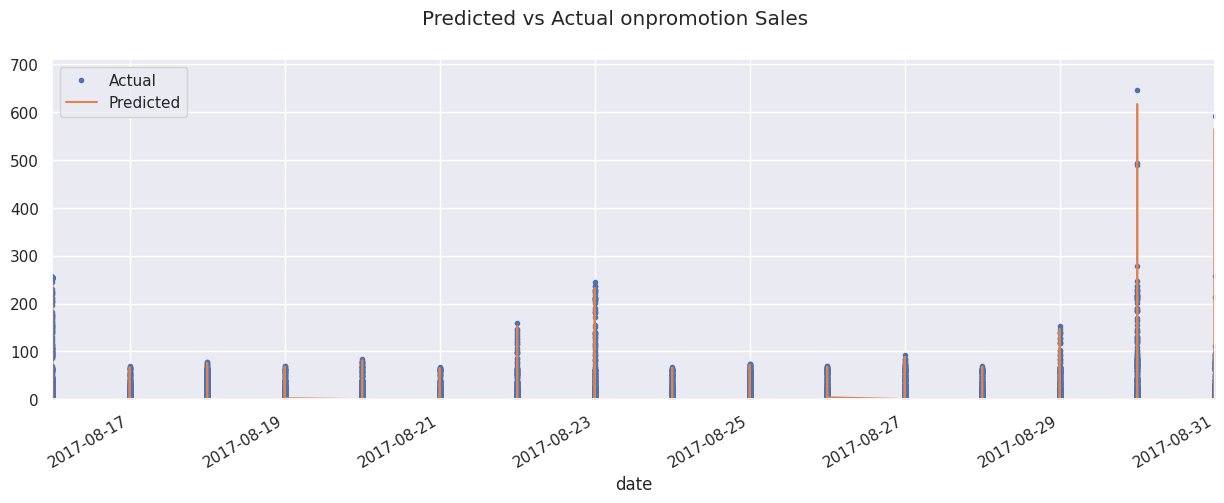

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Y' contains the actual values from the test dataset
# and 'predictions' contains the predictions made by the model
# Ensure 'datum' column exists in df_test for indexing

# Create a DataFrame to hold actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': df_test['onpromotion'].values,  # Actual values from the test dataset
    'Predicted': predictions.flatten(),  # Predictions made by the model
    'date': df_test['date']  # Use the 'date' as the index
})

# Set the 'date' as index
comparison_df.set_index('date', inplace=True)

# Plotting the data
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot actual and predicted values
comparison_df[['Actual', 'Predicted']].plot(ax=ax, style=['.', '-'])

# Optionally set x-axis bounds and y-axis limits
ax.set_xlim(comparison_df.index.min(), comparison_df.index.max())
ax.set_ylim(comparison_df['Actual'].min() * 0.9, comparison_df['Actual'].max() * 1.1)

# Add title
plt.suptitle('Predicted vs Actual onpromotion Sales')

# Show the plot
plt.show()


**Data Sales**

In [24]:
#KEEP

import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# Create the CNN-LSTM model
model_cnn_lstm = Sequential()

# Adding layers
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=1, activation='relu',
                           input_shape=(timesteps, 1))) # L2 regularization
model_cnn_lstm.add(MaxPooling1D(pool_size=1))

model_cnn_lstm.add(LSTM(50, activation='relu'))  # L2 regularization
model_cnn_lstm.add(Dropout(0.2))  # Dropout layer

model_cnn_lstm.add(Dense(1, kernel_regularizer=l2(0.01)))  # Single output for 'M01AB'

# Compile the model
adam = Adam()
model_cnn_lstm.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

#KEEP

In [25]:
# Fit the model
epochs = 50  # Adjust number of epochs as per requirement
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, X_train,
                                      validation_data=(X_val_series_sub, X_val),
                                      epochs=epochs, verbose=2)

Epoch 1/50
46/46 - 5s - 103ms/step - accuracy: 0.0178 - loss: 29.3969 - val_accuracy: 0.0247 - val_loss: 27.3317
Epoch 2/50
46/46 - 0s - 3ms/step - accuracy: 0.0178 - loss: 26.4623 - val_accuracy: 0.0247 - val_loss: 24.1631
Epoch 3/50
46/46 - 0s - 3ms/step - accuracy: 0.0178 - loss: 22.7261 - val_accuracy: 0.0247 - val_loss: 19.9221
Epoch 4/50
46/46 - 0s - 3ms/step - accuracy: 0.0178 - loss: 17.9002 - val_accuracy: 0.0247 - val_loss: 14.6906
Epoch 5/50
46/46 - 0s - 3ms/step - accuracy: 0.0178 - loss: 12.5209 - val_accuracy: 0.0247 - val_loss: 9.2747
Epoch 6/50
46/46 - 0s - 3ms/step - accuracy: 0.0178 - loss: 7.3055 - val_accuracy: 0.0247 - val_loss: 4.8477
Epoch 7/50
46/46 - 0s - 3ms/step - accuracy: 0.0212 - loss: 3.7861 - val_accuracy: 0.0247 - val_loss: 2.1685
Epoch 8/50
46/46 - 0s - 6ms/step - accuracy: 0.0315 - loss: 1.9238 - val_accuracy: 0.0712 - val_loss: 1.0198
Epoch 9/50
46/46 - 0s - 3ms/step - accuracy: 0.0404 - loss: 1.2499 - val_accuracy: 0.0712 - val_loss: 0.6529
Epoch 10

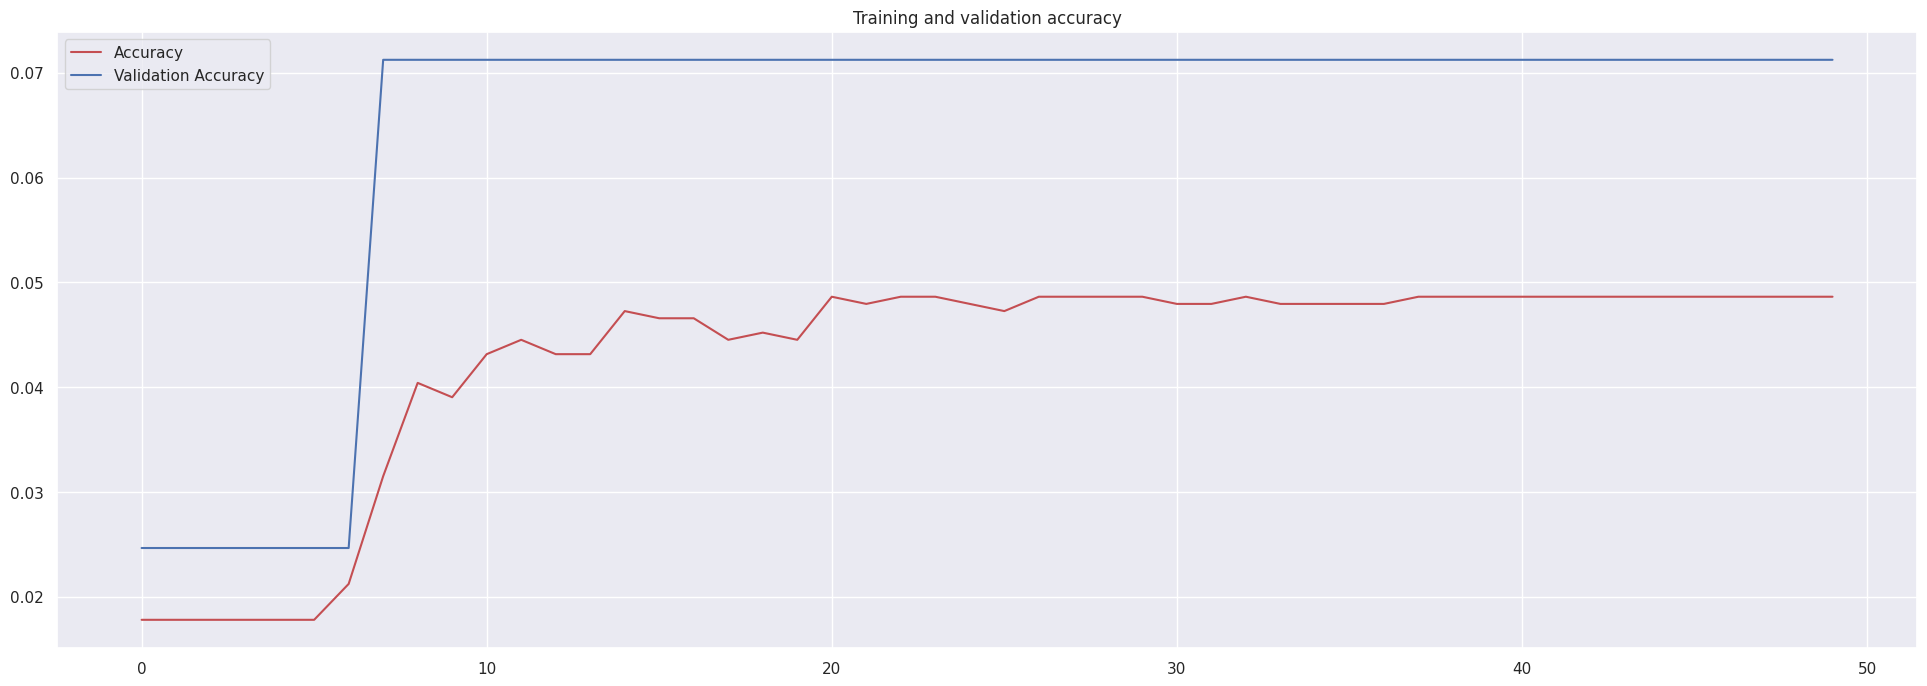

<Figure size 2400x800 with 0 Axes>

In [26]:
acc = cnn_lstm_history.history['accuracy']
val_acc = cnn_lstm_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

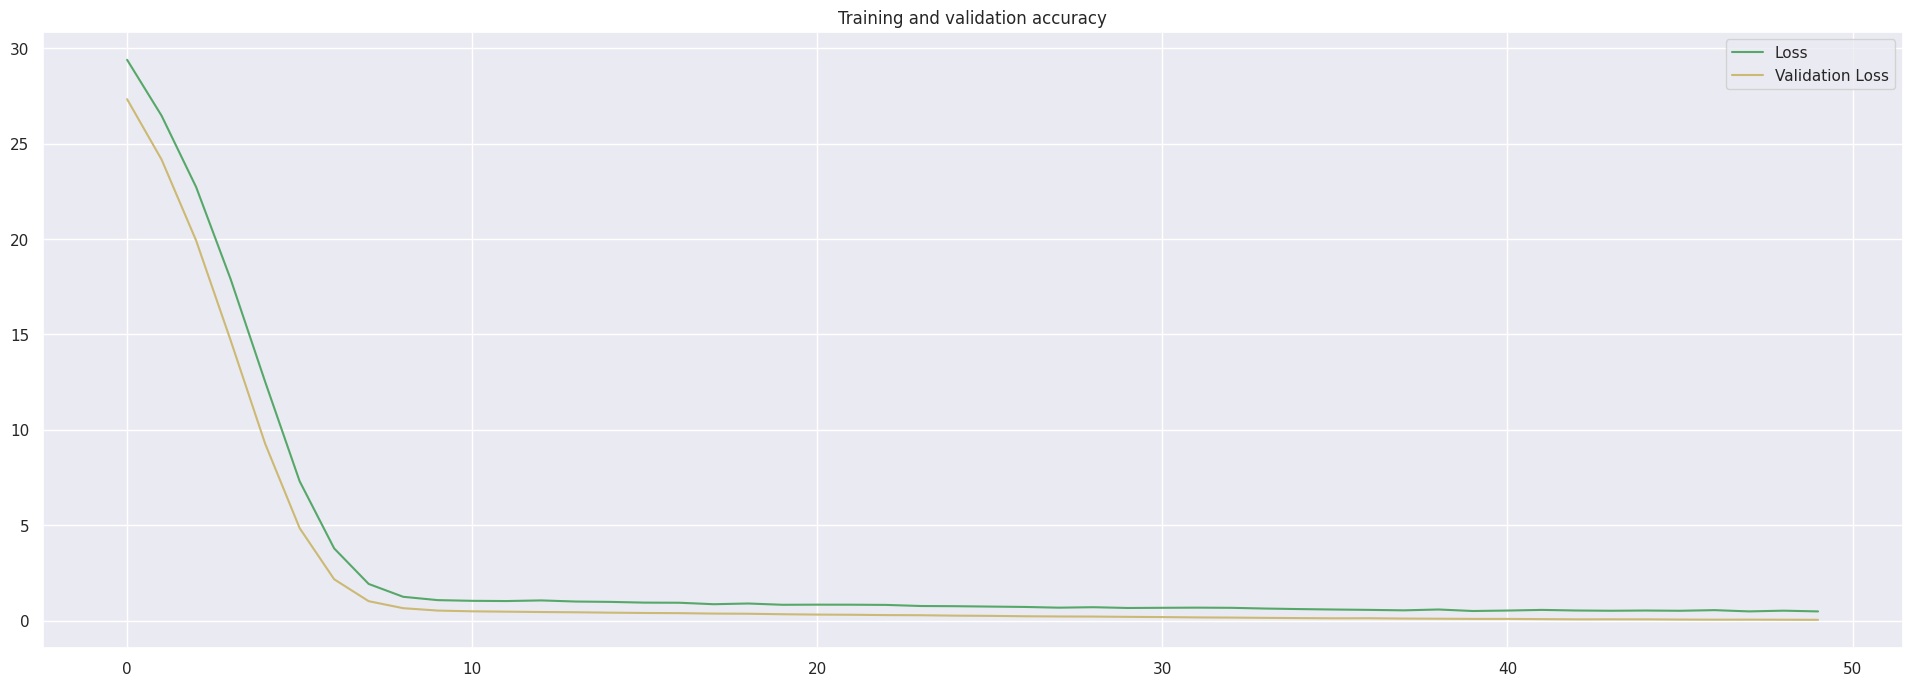

<Figure size 2400x800 with 0 Axes>

In [27]:
loss = cnn_lstm_history.history['loss']
val_loss = cnn_lstm_history.history['val_loss']

plt.plot(epochs, loss, 'g', label='Loss')
plt.plot(epochs, val_loss, 'y', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [28]:


# Evaluate the model
loss, accuracy = model_cnn_lstm.evaluate(X_val_series_sub, X_val, verbose=0)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

# Predict on 2019 data
predictions_2019 = model_cnn_lstm.predict(X_2019_series_sub)

# Calculate the error on 2019 predictions
mse_2019 = mean_squared_error(Y, predictions_2019)
print(f'Mean Squared Error on 2019 data: {mse_2019}')

# Compare actual vs predicted M01AB for 2019
comparison = pd.DataFrame({
    'Actual': Y.flatten(),
    'Predicted': predictions_2019.flatten()
})

print(comparison.head())


Validation Loss: 0.043923355638980865, Validation Accuracy: 0.0712328776717186
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
Mean Squared Error on 2019 data: 0.030871918211715903
   Actual  Predicted
0    0.00   0.288763
1    5.33   5.212779
2    4.33   4.132298
3    7.00   6.995687
4    8.01   8.055167


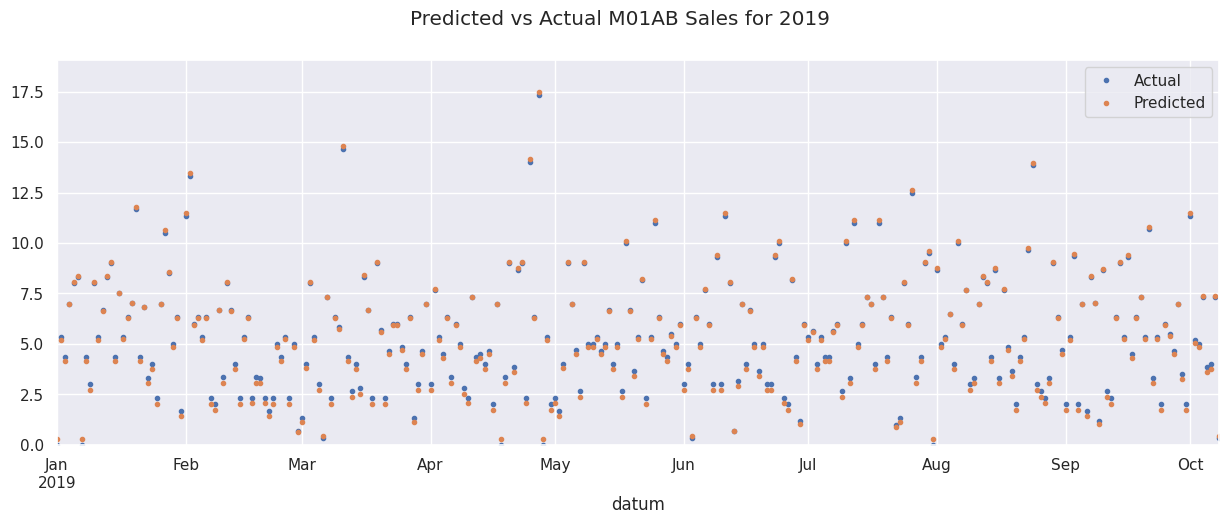

In [35]:
# Create a DataFrame to hold actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': Y.flatten(),
    'Predicted': predictions_2019.flatten(),
    'datum': df_2019['datum'].values  # Use the 'datum' as the date index
})

# Set the 'datum' as index
comparison_df.set_index('datum', inplace=True)

# Plotting the data
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot actual and predicted values
comparison_df[['Actual', 'Predicted']].plot(ax=ax, style=['.','.'])

# Optionally set x-axis bounds and y-axis limits
ax.set_xlim(comparison_df.index.min(), comparison_df.index.max())
ax.set_ylim(comparison_df['Actual'].min() * 0.9, comparison_df['Actual'].max() * 1.1)

# Add title
plt.suptitle('Predicted vs Actual M01AB Sales for 2019')

# Show the plot
plt.show()

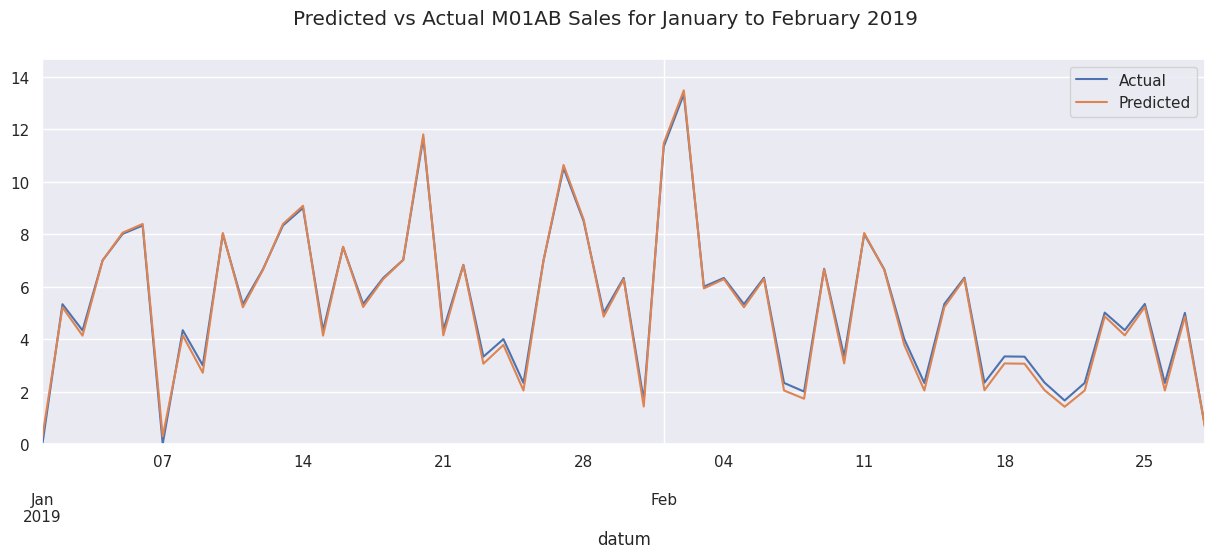

In [30]:
# Filter the comparison DataFrame to include only January and February 2019
comparison_jan_feb = comparison_df[(comparison_df.index >= '2019-01-01') & (comparison_df.index <= '2019-02-28')]

# Plotting the data (January to February)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot actual and predicted values for Jan-Feb
comparison_jan_feb[['Actual', 'Predicted']].plot(ax=ax, style=['-', '-'])

# Set x-axis bounds for January and February
ax.set_xlim(comparison_jan_feb.index.min(), comparison_jan_feb.index.max())

# Optionally set y-axis limits based on the actual values range
ax.set_ylim(comparison_jan_feb['Actual'].min() * 0.9, comparison_jan_feb['Actual'].max() * 1.1)

# Add title
plt.suptitle('Predicted vs Actual M01AB Sales for January to February 2019')

# Show the plot
plt.show()
